In [1]:
# --- Step 1: All Necessary Imports ---

# PyTorch is the main library for deep learning
import torch
# torchvision contains utilities for vision tasks, like transformations
import torchvision.transforms as T
# This gives us access to pre-trained models like ResNet50
import torchvision.models as models
# This utility will help us save our final pattern as a JPG file
from torchvision.utils import save_image

# os is used for interacting with the operating system, like reading file paths
import os
# PIL (Pillow) is a library for opening and manipulating images
from PIL import Image
# matplotlib is for plotting and visualizing images and graphs
import matplotlib.pyplot as plt
# random is used for making random selections, like picking images
import random
# numpy is a library for numerical operations, useful for handling images
import numpy as np
# tqdm gives us a nice progress bar for our loops
from tqdm.notebook import tqdm

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
# --- Step 2: Setting up the Device (GPU or CPU) ---

# We check if a CUDA-enabled GPU is available. Colab provides this for free.
if torch.cuda.is_available():
    # If a GPU is available, we set our device to 'cuda'
    device = torch.device("cuda")
    # This prints the name of the GPU being used (e.g., Tesla T4)
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    # If no GPU is found (e.g., if you didn't enable it), we fall back to using the CPU
    device = torch.device("cpu")
    print("GPU not found, using CPU")

Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
transform = T.Compose([
    T.Resize((256, 128)),
    # 2. Convert the image from a PIL Image object to a PyTorch Tensor.
    T.ToTensor(),
    # 3. Normalize the tensor's pixel values. These specific mean/std values are standard for models pre-trained on ImageNet and help the model perform better.
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
def load_market1501_data(data_dir):
    # This list will store tuples of (image_path, person_id, camera_id)
    all_data = []
    # os.listdir gets all file names in the directory. We iterate through them.
    for filename in os.listdir(data_dir):
        # We only want to process files that are '.jpg' images.
        if filename.endswith('.jpg'):
            # The full path to the image file
            path = os.path.join(data_dir, filename)
            # The filename looks like '0001_c1s1_000151_01.jpg'. We split it by the '_' character.
            parts = filename.split('_')
            # The first part '0001' is the person ID (pid). We convert it to an integer.
            pid = int(parts[0])
            # The second part is 'c1s1'. The camera ID is the number after 'c'. We extract it.
            camid = int(parts[1][1])
            
            # The person ID '-1' is used for background images or distractors, which we ignore.
            if pid == -1:
                continue
            
            # We add the parsed information to our list.
            all_data.append((path, pid, camid))
    # Return the list of all processed image data.
    return all_data

In [5]:
# --- Load the actual data ---
# The directory containing the training images of the Market-1501 dataset.
# Make sure you have downloaded and unzipped it in your project folder.
train_dir = 'Market-1501-v15.09.15/bounding_box_train'
# Call our function to load the data.
all_train_data = load_market1501_data(train_dir)

# --- Group images by Person ID for easier triplet sampling later ---
# This dictionary will map each person ID to a list of their images.
pid_to_paths = {}
# We iterate through all the data we just loaded.
for path, pid, camid in all_train_data:
    # If we haven't seen this person ID before, create a new empty list for it.
    if pid not in pid_to_paths:
        pid_to_paths[pid] = []
    # Add the current image's info to the list for this person.
    pid_to_paths[pid].append((path, camid))

# Get a list of all unique person IDs available in the dataset.
unique_pids = list(pid_to_paths.keys())

# Print a summary to confirm everything loaded correctly.
print(f"Loaded {len(all_train_data)} images from {len(unique_pids)} unique people.")

Loaded 12936 images from 751 unique people.


In [6]:
# --- Replace your current Step 4 with this NEW, SIMPLER version ---
import torchreid

print("Attempting to download the pre-trained Re-ID model automatically...")

# We will use the 'pretrained=True' flag which tells the library to
# automatically download the correct weights from the official source.
# This is more robust than using a manual link.
model = torchreid.models.build_model(
    name='osnet_x1_0',
    num_classes=751, # Number of identities in Market-1501 training set
    loss='triplet',
    pretrained=True # This flag will trigger the automatic download
)

# Move the model to the GPU and set to evaluation mode
model = model.to(device)
model.eval()

# The model from torchreid is already a feature extractor, so we can use it directly.
feature_extractor = model

# Freeze the model's parameters
for param in feature_extractor.parameters():
    param.requires_grad = False

print("Victim model (TorchReID OSNet) is loaded and frozen successfully!")

c:\Users\Public\anaconda3\envs\pytorch_env\Lib\site-packages\torchreid\reid\metrics\rank.py:11: UserWarning: Cython evaluation (very fast so highly recommended) is unavailable, now use python evaluation.
  warnings.warn(


Attempting to download the pre-trained Re-ID model automatically...
Successfully loaded imagenet pretrained weights from "C:\Users\Uday Raj/.cache\torch\checkpoints\osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


c:\Users\Public\anaconda3\envs\pytorch_env\Lib\site-packages\torchreid\reid\models\osnet.py:482: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cached

Victim model (TorchReID OSNet) is loaded and frozen successfully!


In [7]:
# --- Step 5: Initializing the Adversarial Pattern (δ) and Mask (Mx) ---
# (This is identical to the evading attack setup)
pattern_size = (256, 128)
mask = torch.zeros(1, 1, pattern_size[0], pattern_size[1], device=device)
mask[:, :, 50:200, 30:100] = 1

In [8]:
# --- Step 6: Implementing Transformations (Ti) and Overlay (o) ---
# (This is identical to the evading attack setup)
def apply_pattern(image_tensor, pattern, mask):
    perspective_transform = T.RandomPerspective(distortion_scale=0.2, p=1.0)
    transformed_pattern = perspective_transform(pattern)
    transformed_mask = perspective_transform(mask)
    adversarial_image = (1 - transformed_mask) * image_tensor + transformed_mask * transformed_pattern
    return adversarial_image

In [9]:
# --- Step 7: Implementing the Loss Functions ---
# (This is identical to the evading attack setup)
cosine_similarity = torch.nn.CosineSimilarity(dim=1)
def total_variation_loss(image):
    tv_h = torch.pow(image[:, :, 1:, :] - image[:, :, :-1, :], 2).sum()
    tv_w = torch.pow(image[:, :, :, 1:] - image[:, :, :, :-1], 2).sum()
    return (tv_h + tv_w)

In [10]:
# --- Step 8: The Full Optimization Loop for IMPERSONATION (Implementing Equation 9) ---

# --- The Adversarial Pattern ---
# We initialize the pattern we want to optimize.
# We make it a torch.nn.Parameter so the optimizer can find and update it.
adv_pattern = torch.nn.Parameter(torch.rand(1, 3, 256, 128, device=device))

# --- The Optimizer ---
# We use the Adam optimizer, as specified in the paper.
optimizer = torch.optim.Adam([adv_pattern], lr=0.01)

# --- Hyperparameters from the Formulas ---
# These are the "knobs" for the impersonation attack loss function.
lambda1 = 1.0   # (from Eq. 6) Controls the "pull together" force for same-camera images.
lambda2 = 1.0   # (from Eq. 6) Controls the "push apart" force for different-camera images.
kappa = 0.1     # (from Eq. 9) Controls the strength of the smoothness loss.

In [12]:
# --- The Training Loop ---
num_iterations = 1000  # Targeted attacks are harder, so we might need more iterations.
print("\nStarting IMPERSONATION pattern generation...")

# We use tqdm to create a progress bar for our loop.
for i in tqdm(range(num_iterations), desc="Generating Impersonation Pattern"):

    # --- Step 8.1: Sample a Quadruplet (xo, x+, x-, tk) ---
    while True:
        try:
            # Get a random person ID for the attacker (adversary).
            adversary_pid = random.choice(unique_pids)
            # Get a different random person ID for the target.
            target_pid = random.choice([p for p in unique_pids if p != adversary_pid])

            # Get image paths for the adversary.
            adversary_paths_cams = pid_to_paths[adversary_pid]
            # Get one random image to be the anchor (xo).
            anchor_path, anchor_cam = random.choice(adversary_paths_cams)

            # Find a positive image (x+): another image of the adversary from the SAME camera.
            positive_path, _ = random.choice([item for item in adversary_paths_cams if item[1] == anchor_cam and item[0] != anchor_path])

            # Find a negative image (x-): an image of the adversary from a DIFFERENT camera.
            negative_path, _ = random.choice([item for item in adversary_paths_cams if item[1] != anchor_cam])

            # Get a random image of the target person (tk).
            target_path, _ = random.choice(pid_to_paths[target_pid])

            # If all samples are found successfully, break the loop.
            break
        except IndexError:
            # If we fail to find a valid triplet (e.g., person only has 1 image in a camera),
            # just re-run the whole sampling process.
            continue

    # Load and transform the quadruplet images into tensors.
    anchor_img = transform(Image.open(anchor_path).convert('RGB')).unsqueeze(0).to(device)
    positive_img = transform(Image.open(positive_path).convert('RGB')).unsqueeze(0).to(device)
    negative_img = transform(Image.open(negative_path).convert('RGB')).unsqueeze(0).to(device)
    target_img = transform(Image.open(target_path).convert('RGB')).unsqueeze(0).to(device)

    # --- Step 8.2: Apply Pattern and Degradations (ϕ(...) from Eq. 9) ---
    degradation = T.Compose([ T.ColorJitter(brightness=0.2, contrast=0.2) ])
    adv_anchor = apply_pattern(degradation(anchor_img), adv_pattern, mask)

    # --- Step 8.3: Get Feature Vectors ---
    anchor_features = feature_extractor(adv_anchor).flatten(1)
    positive_features = feature_extractor(positive_img).flatten(1) # Note: pattern not applied to pos/neg
    negative_features = feature_extractor(negative_img).flatten(1) # in this formulation for simplicity
    target_features = feature_extractor(target_img).flatten(1)

    # --- Step 8.4: Calculate the Total Loss (Equation 9) ---
    # Equation 6 is a maximization problem. To use PyTorch's minimizers, we minimize the negative of it.
    # Loss = - (sim_target + λ1*sim_pos - λ2*sim_neg)
    # Loss = -sim_target - λ1*sim_pos + λ2*sim_neg

    # 1. Similarity to Target: We want to MAXIMIZE this. So in the loss, it becomes negative.
    sim_target = cosine_similarity(anchor_features, target_features)

    # 2. Similarity to Positive: We want to MAXIMIZE this (pull same-camera images together).
    sim_pos = cosine_similarity(anchor_features, positive_features)

    # 3. Similarity to Negative: We want to MINIMIZE this (push different-camera images apart).
    sim_neg = cosine_similarity(anchor_features, negative_features)

    # The main adversarial part of the loss.
    impersonation_loss = -10.0 * sim_target - lambda1 * sim_pos + lambda2 * sim_neg

    # The smoothness part of the loss.
    tv_loss = total_variation_loss(adv_pattern * mask)

    # The final combined loss from Equation 9.
    total_loss = impersonation_loss + kappa * tv_loss

    # --- Step 8.5: Optimize the Pattern ---
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # --- Step 8.6: Enforce Printable Colors Constraint (δ ∈ P from Eq. 9) ---
    with torch.no_grad():
        adv_pattern.data.clamp_(0, 1)

print("\nImpersonation pattern generation complete!")


Starting IMPERSONATION pattern generation...


Generating Impersonation Pattern:   0%|          | 0/1000 [00:00<?, ?it/s]


Impersonation pattern generation complete!


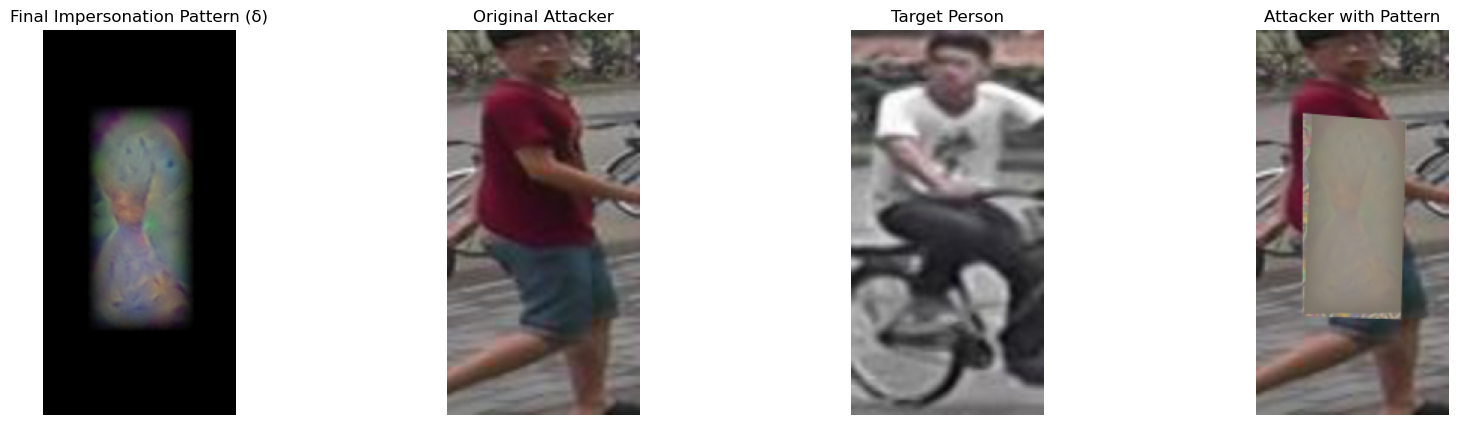

In [14]:
# --- Step 9: Visualization and Simplified Evaluation ---

# --- Visualize the pattern ---
final_pattern_numpy = (adv_pattern * mask).detach().cpu().squeeze(0).permute(1, 2, 0).numpy()

# --- Get a sample attacker and target image to test on ---
# We'll grab two different people from our training data list.
attacker_path, _, _ = all_train_data[0] # Person 0001
target_path, _, _ = all_train_data[100] # A different person
attacker_img_tensor = transform(Image.open(attacker_path).convert('RGB')).unsqueeze(0).to(device)
target_img_tensor = transform(Image.open(target_path).convert('RGB')).unsqueeze(0).to(device)

# --- Apply our final pattern to the attacker's image ---
adv_attacker_img_tensor = apply_pattern(attacker_img_tensor, adv_pattern, mask)

# --- Create a helper function for displaying tensors ---
def imshow_tensor(tensor, title=""):
    unnormalize = T.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img_np = unnormalize(tensor.detach()).cpu().squeeze(0).permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)
    plt.imshow(img_np)
    plt.title(title)
    plt.axis('off')

# --- Plot everything ---
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(final_pattern_numpy)
plt.title("Final Impersonation Pattern (δ)")
plt.axis('off')

plt.subplot(1, 4, 2)
imshow_tensor(attacker_img_tensor, title="Original Attacker")

plt.subplot(1, 4, 3)
imshow_tensor(target_img_tensor, title="Target Person")

plt.subplot(1, 4, 4)
imshow_tensor(adv_attacker_img_tensor, title="Attacker with Pattern")
plt.show()

In [15]:
# --- Simplified Quantitative Check ---
# The main goal is to increase the similarity between the attacker and the target.
print("\n--- Similarity Scores for Impersonation ---")

# Get features for the original attacker and the target
feat_attacker_orig = feature_extractor(attacker_img_tensor).flatten(1)
feat_target = feature_extractor(target_img_tensor).flatten(1)

# Get features for the attacker wearing the pattern
feat_attacker_adv = feature_extractor(adv_attacker_img_tensor).flatten(1)

# Calculate similarity scores
sim_before = cosine_similarity(feat_attacker_orig, feat_target).item()
sim_after = cosine_similarity(feat_attacker_adv, feat_target).item()

print(f"Similarity (Attacker vs. Target) BEFORE attack: {sim_after:.4f}")
print(f"Similarity (Attacker vs. Target) AFTER attack:  {sim_before:.4f}")

if sim_after < sim_before:
    print("\nSUCCESS: The pattern made the attacker look MORE like the target to the AI.")
else:
    print("\nNOTE: The pattern did not increase similarity. Try running for more iterations or tuning hyperparameters.")


--- Similarity Scores for Impersonation ---
Similarity (Attacker vs. Target) BEFORE attack: 0.5317
Similarity (Attacker vs. Target) AFTER attack:  0.6144

SUCCESS: The pattern made the attacker look MORE like the target to the AI.


In [16]:
# Import the 'save_image' utility from torchvision
from torchvision.utils import save_image

# --- The line to save the pattern ---
# We take our final optimized pattern tensor 'adv_pattern'.
# The save_image function handles the conversion from a tensor in the [0, 1] range to a standard image file.
# We'll save it as 'adversarial_pattern.jpg' in your project folder.
save_image(adv_pattern, 'adversarial_pattern_impersonation.jpg')

print("Adversarial pattern has been saved as 'adversarial_pattern_impersonation.jpg'")

Adversarial pattern has been saved as 'adversarial_pattern_impersonation.jpg'
